In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import cv2

from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

In [2]:
# read in dataframe with image data and extras
df = pd.read_pickle("even_classes.pkl")

In [3]:
# check for useless columns that have no variance and drop em
to_drop = []

for col in df.columns:
    if isinstance(df[col][0],np.ndarray):
        print("--------------------------------------")
    else:
        print(f"{col.capitalize()} has {len(df[col].unique())} different values.")
        if len(df[col].unique()) == 1:
            to_drop.append(col)
        
df = df.drop(to_drop, axis=1)
df.info()

Name has 12784 different values.
--------------------------------------
Origin has 3 different values.
Label has 8 different values.
Dim has 114 different values.
Height has 29 different values.
Width has 33 different values.
Channels has 1 different values.
Datatype has 1 different values.
--------------------------------------
Img_lum has 12758 different values.
Img_bright has 12764 different values.
N_black_pix has 39 different values.
--------------------------------------
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12784 entries, 18838 to 34704
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         12784 non-null  object 
 1   img_data     12784 non-null  object 
 2   origin       12784 non-null  object 
 3   label        12784 non-null  object 
 4   dim          12784 non-null  object 
 5   height       12784 non-null  int64  
 6   width        12784 non-nu

In [4]:
# get the image arrays
data = df.img_data

# turn target variable into numerical
encoder = LabelEncoder()
target = encoder.fit_transform(df.label)
target = to_categorical(target)

In [5]:
# shuffle the data
data, target = shuffle(data, target)

In [6]:
# only using image arrays!

#train test split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2)

#train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15)
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

8692 8692
1535 1535
2557 2557


In [7]:
# gotta stack them 
X_train = np.stack(X_train, axis=0)
X_val = np.stack(X_val, axis=0)
X_test = np.stack(X_test, axis=0)

In [8]:
# use tf.data instead of imagegenerators
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [9]:
# augmentation layer

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.CenterCrop(360,360)])

In [10]:
# manual f1_score implementation

from tensorflow.keras import backend as K

def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
# manulally create data batches (instead of using generators)
train_data_batches = training_data.shuffle(buffer_size=len(X_train)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data_batches = validation_data.shuffle(buffer_size=len(X_val)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# function to create NN 
def create_model(n_classes, fine_tuning = "none"):
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(360, 360, 3))
    
    #with fine tuning
    if isinstance(fine_tuning, int):
        for layer in base_model.layers[:fine_tuning]:
            layer.trainable = False
        for layer in base_model.layers[fine_tuning:]:
            layer.trainable = True
        optimizer = Adam(learning_rate=.0001)
        
    else:
        for layer in base_model.layers:
            layer.trainable = False
        optimizer = Adam(learning_rate=.001)
            
    inputs = Input(shape=(360, 360, 3))
    rescale = tf.keras.applications.resnet_v2.preprocess_input(inputs)
    augmented = data_augmentation(rescale)
    resnet = base_model(augmented)
    pooling = layers.GlobalAveragePooling2D()(resnet)
    flatten = layers.Flatten()(pooling)
    #dropout = layers.Dropout(0.2)(pooling)
    hidden1 = Dense(80, activation="tanh")(flatten)
    outputs = Dense(n_classes, activation="softmax")(hidden1)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=[f1])
    
    print(model.summary())

    return model

In [13]:
# create the model through the function, print summary and add callbacks

model_no_ft = create_model(n_classes=8) # no fine tuning for now, every layer of base model resnet is frozen

#callback function to reduce learning rate when needed
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='f1', factor=0.8,
                                                 patience=3, min_lr=1e-5, verbose=1)

#another callback function to stop when no improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", patience=5)

history = model_no_ft.fit(train_data_batches,
                          epochs = 15, 
                          validation_data=valid_data_batches, 
                          callbacks=[reduce_lr, early_stop])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 360, 360, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 360, 360, 3)      0         
 a)                                                              
                                                                 
 sequential (Sequential)     (None, 360, 360, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 12, 12, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

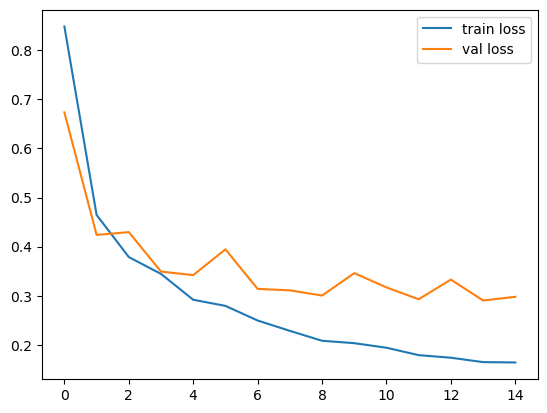

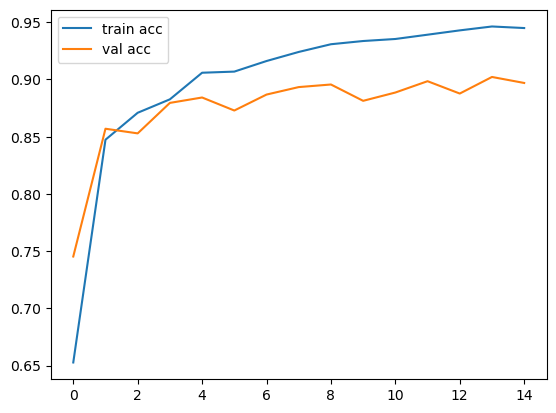

In [14]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossValLoss_f1_no_dropout_plus_flatten.png')
plt.show()

# plot the accuracy
plt.plot(history.history['f1'], label='train acc')
plt.plot(history.history['val_f1'], label='val acc')
plt.legend()
plt.savefig('f1_acc_no_dropout_plus_flatten.png')
plt.show()

In [15]:
# evaluate the model with test_generator
score = model_no_ft.evaluate(x=X_test, y=y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

80/80 [==============================] - 168s 2s/step - loss: 0.2633 - f1: 0.9109
Test loss: 0.26328375935554504
Test accuracy: 0.9109117388725281


In [16]:
# compare predicted and actual classes
from sklearn.metrics import accuracy_score, f1_score

predicted = model_no_ft.predict(X_test)                  # predicted values or probabilities?
predicted_classes = np.argmax(predicted, axis=-1)        # predicted classes

true_classes = np.argmax(y_test, axis=-1)                # reverse the to_categorical transformation back to classes int's

acc_score = accuracy_score(true_classes, predicted_classes)
f1_score = f1_score(true_classes, predicted_classes, average="weighted")
print(f"ResNet50V2 Model Accuracy without Fine-Tuning: {round(acc_score * 100, 2)}")
print(f"ResNet50V2 Model F1 Score without Fine-Tuning: {round(f1_score * 100, 2)}")

80/80 [==============================] - 164s 2s/step
ResNet50V2 Model Accuracy without Fine-Tuning: 90.97
ResNet50V2 Model F1 Score without Fine-Tuning: 90.89


In [23]:
# Followingly are the f1 scores obtained based on certain modifications:

# No data augmentation whatsoever:                                                    85.98 on TEST SET
# basic data augmentation (randomflip & randomrotation) results in small increase:    86.12 on TEST SET
# adding random contrast resulted in:                                                 0.8219 on TRAIN 0.7464 on VAL (no TEST score)
# basic data aug + central crop:                                                      87.81 on TEST SET

# (horrible training scores when including random brightness in data augmentation!!! not even 10% f1 score while training)

# BEST SO FAR:
# basic data aug + central crop + no dropout layers + flatten + dense after average pooling: 91.42 on TEST SET

In [17]:
pd.crosstab(true_classes, predicted_classes, rownames=["True"], colnames=["Predicted"])

Predicted,0,1,2,3,4,5,6,7
True,,,,,,,,
0,301,1,2,5,4,3,1,1
1,4,289,0,0,0,9,19,0
2,3,0,320,2,4,0,0,8
3,22,4,11,244,7,22,6,1
4,1,4,6,0,297,7,5,0
5,0,5,2,7,17,271,7,0
6,0,9,1,2,8,5,291,2
7,0,0,0,1,0,0,3,313


In [18]:
# get the layer index from where we want to fine tune
layer_name = model_no_ft.get_layer("resnet50v2").get_layer("conv5_block1_preact_bn")
layer_index = model_no_ft.get_layer("resnet50v2").layers.index(layer_name)
layer_index

154

In [19]:
# time to fine tune the previous model by unfreezing the last (5th) block of the base model resnet
model_ft = create_model(n_classes=8, fine_tuning=layer_index)

history_ft = model_ft.fit(train_data_batches,
                          epochs = 25, 
                          validation_data=valid_data_batches, 
                          callbacks=[reduce_lr, early_stop])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 360, 360, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 360, 360, 3)      0         
 bda)                                                            
                                                                 
 sequential (Sequential)     (None, 360, 360, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 12, 12, 2048)      23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [20]:
# save model
model_ft.save('Best_model_ft_5th_layer.h5')

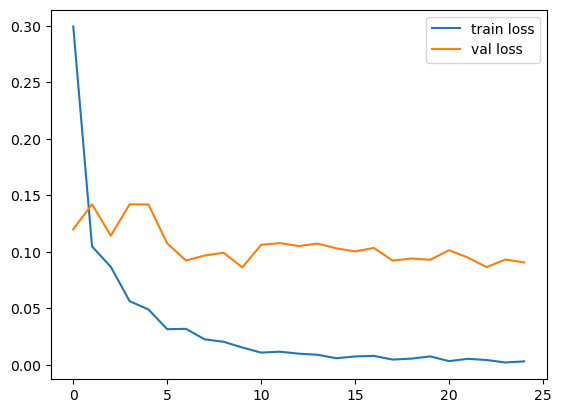

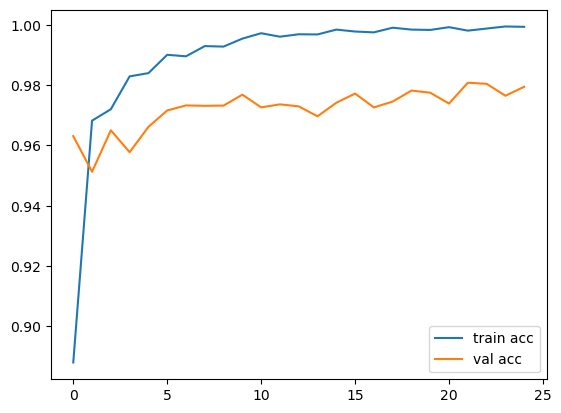

In [21]:
# plot the loss
plt.plot(history_ft.history['loss'], label='train loss')
plt.plot(history_ft.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossValLoss_ft5.png')
plt.show()

# plot the accuracy
plt.plot(history_ft.history['f1'], label='train acc')
plt.plot(history_ft.history['val_f1'], label='val acc')
plt.legend()
plt.savefig('f1_acc_ft5.png')
plt.show()

In [22]:
# evaluate the model with test_generator
score = model_ft.evaluate(x=X_test, y=y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

80/80 [==============================] - 164s 2s/step - loss: 0.0854 - f1: 0.9803
Test loss: 0.08538749814033508
Test accuracy: 0.980291485786438


In [23]:
# compare predicted and actual classes
from sklearn.metrics import accuracy_score, f1_score

predicted_ft = model_ft.predict(X_test)                        # predicted values or probabilities?
predicted_classes_ft = np.argmax(predicted_ft, axis=-1)        # predicted classes

true_classes_ft = np.argmax(y_test, axis=-1)                # equal to y_test

acc_score_ft = accuracy_score(true_classes_ft, predicted_classes_ft)
f1_score_ft = f1_score(true_classes_ft, predicted_classes_ft, average="macro")
print(f"ResNet50V2 Model Accuracy with Fine-Tuning: {round(acc_score_ft * 100, 2)}")
print(f"ResNet50V2 Model F1 Score with Fine-Tuning: {round(f1_score_ft * 100, 2)}")

80/80 [==============================] - 163s 2s/step
ResNet50V2 Model Accuracy with Fine-Tuning: 98.01
ResNet50V2 Model F1 Score with Fine-Tuning: 97.99


In [24]:
pd.crosstab(true_classes_ft, predicted_classes_ft, rownames=["True"], colnames=["Predicted"])

Predicted,0,1,2,3,4,5,6,7
True,,,,,,,,
0,313,2,0,1,0,1,1,0
1,1,313,0,1,1,0,5,0
2,1,0,336,0,0,0,0,0
3,0,0,0,312,2,2,1,0
4,0,0,0,1,314,5,0,0
5,0,1,0,5,7,296,0,0
6,2,1,0,6,1,3,305,0
7,0,0,0,0,0,0,0,317


In [25]:
# forgot to print the summary of the fine tuned model
model_ft.summary(expand_nested=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 360, 360, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 360, 360, 3)      0         
 bda)                                                            
                                                                 
 sequential (Sequential)     (None, 360, 360, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| random_flip (RandomFlip)  (None, 360, 360, 3)       0         |
|                                                               |
| random_rotation (RandomRota  (None, 360, 360, 3)    0    

| tion)                                                         |
|                                                               |
| max_pooling2d_3 (MaxPooling  (None, 45, 45, 256)    0         |
| 2D)                                                           |
|                                                               |
| conv2_block3_3_conv (Conv2D  (None, 45, 45, 256)    16640     |
| )                                                             |
|                                                               |
| conv2_block3_out (Add)    (None, 45, 45, 256)       0         |
|                                                               |
| conv3_block1_preact_bn (Bat  (None, 45, 45, 256)    1024      |
| chNormalization)                                              |
|                                                               |
| conv3_block1_preact_relu (A  (None, 45, 45, 256)    0         |
| ctivation)                                                    |
|         

| ding2D)                                                       |
|                                                               |
| conv3_block4_2_conv (Conv2D  (None, 23, 23, 128)    147456    |
| )                                                             |
|                                                               |
| conv3_block4_2_bn (BatchNor  (None, 23, 23, 128)    512       |
| malization)                                                   |
|                                                               |
| conv3_block4_2_relu (Activa  (None, 23, 23, 128)    0         |
| tion)                                                         |
|                                                               |
| max_pooling2d_4 (MaxPooling  (None, 23, 23, 512)    0         |
| 2D)                                                           |
|                                                               |
| conv3_block4_3_conv (Conv2D  (None, 23, 23, 512)    66048     |
| )       

| )                                                             |
|                                                               |
| conv4_block4_1_bn (BatchNor  (None, 23, 23, 256)    1024      |
| malization)                                                   |
|                                                               |
| conv4_block4_1_relu (Activa  (None, 23, 23, 256)    0         |
| tion)                                                         |
|                                                               |
| conv4_block4_2_pad (ZeroPad  (None, 25, 25, 256)    0         |
| ding2D)                                                       |
|                                                               |
| conv4_block4_2_conv (Conv2D  (None, 23, 23, 256)    589824    |
| )                                                             |
|                                                               |
| conv4_block4_2_bn (BatchNor  (None, 23, 23, 256)    1024      |
| malizati

| conv5_block1_out (Add)    (None, 12, 12, 2048)      0         |
|                                                               |
| conv5_block2_preact_bn (Bat  (None, 12, 12, 2048)   8192      |
| chNormalization)                                              |
|                                                               |
| conv5_block2_preact_relu (A  (None, 12, 12, 2048)   0         |
| ctivation)                                                    |
|                                                               |
| conv5_block2_1_conv (Conv2D  (None, 12, 12, 512)    1048576   |
| )                                                             |
|                                                               |
| conv5_block2_1_bn (BatchNor  (None, 12, 12, 512)    2048      |
| malization)                                                   |
|                                                               |
| conv5_block2_1_relu (Activa  (None, 12, 12, 512)    0         |
| tion)   

In [26]:
for l in model_ft.get_layer("resnet50v2").layers:
    print(l.name, l.trainable)

input_3 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d_3 False
conv2_block3_3_conv False
conv2_block3_out False
conv3_block1_p